<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2023TeamB/blob/main/ETL_and_Implementing_DWH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Erstellung eines Datawarehouse für das ANTICOVIS-Projekts
---

## Einleitung
Mit diesem Skript wird ein Datenwarehaouse(DWH) erstellt um ein effizientes und zielgerichtetes Antworten der Forschungsfragestellung zu ermöglichen. Zudem gewärleistet das Datenwarehouse eine verbesserte Datenqualität sowie  eine zuverlässige Datenkonsistenz und Sicherheit.

Das hier erzeugte Datawarehouse wird nach einem Star-schema konstruiert. Yunächst werden alle benötigten DWH Tabellen erzeugt. Dann werden die Dimensionstabellen und dann die Faktentabelle mit Daten aus den Stagingtabellen der Anticovis Datenbank nach einem ETL Prozess und Pseudonymisierung der sensiblen Daten befüllt. 


---
## benötigte python Module werden geladen


In [74]:
import sqlite3
from sqlite3 import Error
import pandas
from pandas import DataFrame
import numpy as np
!pip install pandasql
from pandasql import sqldf
import random
import string

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Angaben zur systemumgebung und den verweendeten python Module

In [75]:
# Python-Version
print("Python-Version:")
!python --version

# sqlite3-Version
print("\n" + "sqlite3-Version:")
sqlite3.sqlite_version

# Pandas-Version
print("\n" + "Pandas-Version:")
print(pandas.__version__)

# numpy-Version
print("\n" + "numpy-Version:")
print(np. __version__)

Python-Version:
Python 3.8.10

sqlite3-Version:

Pandas-Version:
1.3.5

numpy-Version:
1.21.6


#Vorbereitung
Montieren des google Drive

Festlegen des Pfads zur Anticovis Quelldatenbank.

Festlegen des Pfads zum Ablageort des in diesem Skript erzeugten DWH.

In [76]:
from google.colab import drive
drive.mount('/content/drive')

# path of Anticovis quelldatenbank
DB_SOURCE_PATH = f"/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/source_dbs/Source_covid19_Staging.db"

# path of datawarehouse
DB_DWH_PATH = f"/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/source_dbs/DWH_covid19.db"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Erzeugung des DWH

---



##Definition eines DWH ObjeKt welsches die benötigten DWH Tabellen enthält

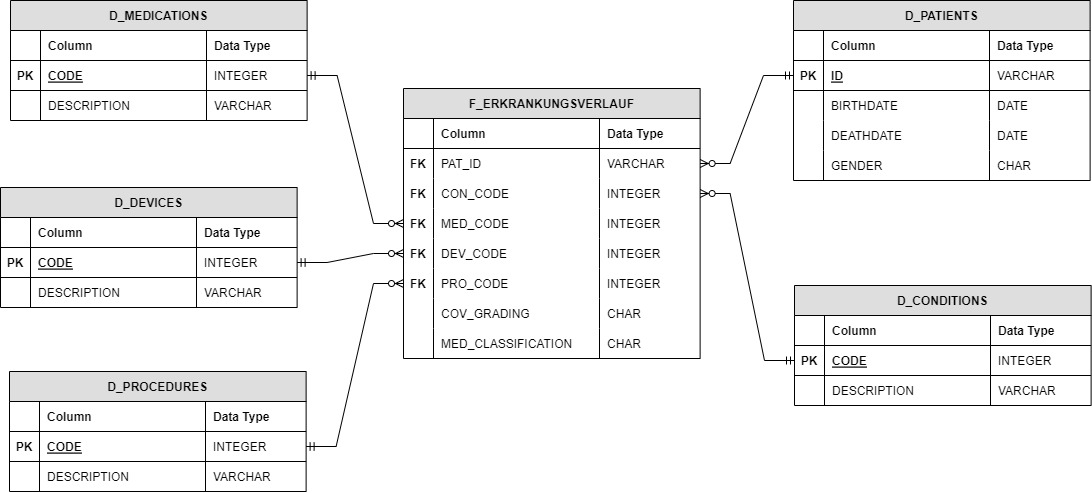

In [77]:
class DB(object):
  def __init__(self, db_file):
    self.conn = sqlite3.connect(db_file)
    self.cur = self.conn.cursor()
    self.__init_db()
  
  def __del__(self):
      self.conn.commit()
      self.conn.close()

  def __init_db(self):
## sql queries to create tables in Datawarehouse 

#  sql query to create d_conditions table
    create_d_conditions = """CREATE TABLE IF NOT EXISTS d_conditions (
                           CONDITIONS_CODE INTERGER PRIMARY KEY,
                           CONDITIONS_DESCRIPTION VARCHAR
                       );"""

#  sql query to create d_devices table
    create_d_devices = """CREATE TABLE IF NOT EXISTS d_devices (
                            DEVICES_CODE INTERGER PRIMARY KEY,
                            DEVICES_DESCRIPTION VARCHAR
                           );"""

#  sql query to create d_medications table
    create_d_medications = """CREATE TABLE IF NOT EXISTS d_medications (
                            MEDICATIONS_CODE INTERGER PRIMARY KEY,
                            MEDICATIONS_DESCRIPTION VARCHAR
                            MEDICATIONS_CODE
                           );"""

#  sql query to create d_procedures table
    create_d_procedures = """CREATE TABLE IF NOT EXISTS d_procedures (
                            PROCEDURES_CODE INTERGER PRIMARY KEY,
                            PROCEDURES_DESCRIPTION VARCHAR
                           );"""

#  sql query to create d_patients table
    create_d_patients = """CREATE TABLE IF NOT EXISTS d_patients (
                            PATIENTS_ID VARCHAR PRIMARY KEY,
                            PATIENTS_BIRTHDATE DATE,
                            PATIENTS_DEATHDATE DATE,
                            PATIENTS_GENDER CHAR
                           );""" 

# sql query to create F_ANTICOVIS table
    create_F_ANTICOVIS = """CREATE TABLE IF NOT EXISTS F_ANTICOVIS (
                           PATIENTS_ID VARCHAR,
                           CONDITIONS_CODE INTERGER,
                           PROCEDURES_CODE INTERGER,
                           DEVICES_CODE INTERGER,
                           MEDICATIONS_CODE INTERGER,
                           MED_CLASSIFICATION INT DEFAULT '0', 
                           COV_GRADING INT DEDAULT '0',
                           FOREIGN KEY (PATIENTS_ID)
                              REFERENCES d_patients (PATIENTS_ID),
                           FOREIGN KEY (CONDITIONS_CODE)
                              REFERENCES d_conditions (CONDITIONS_CODE),
                           FOREIGN KEY (PROCEDURES_CODE)
                              REFERENCES d_procedures (PROCEDURES_CODE),
                           FOREIGN KEY (DEVICES_CODE)
                              REFERENCES d_devices(DEVICES_CODE),
                           FOREIGN KEY (MEDICATIONS_CODE)
                              REFERENCES d_medications (MEDICATIONS_CODE)
                       );"""
    create_tables =  [create_d_conditions,# conditions dimension
                      create_d_devices,# devices dimension
                      create_d_medications,# medications dimension
                      create_d_procedures, # procedures dimension
                      create_d_patients, #patients dimension
                      create_F_ANTICOVIS #Factstable
                      ]

    if self.conn is not None:
      for query in create_tables:
          self.cur.execute(query)
    else:
      print('Connection to database failed')

## Definition der für den ETL prozess benötigten Funktionen

In [78]:
# exporting queries
class SqlQuery:
  def __init__(self, source_table, column_names, sink_table):
    self.source_table = source_table
    self.column_numbers = len(column_names)
    self.column_names = ', '.join(column_names)
    self.sink_table = sink_table

  def extract_query(self):
    return 'SELECT ' + self.column_names + ' FROM ' + self.source_table 

  def load_query(self):
    values_str = '?,' * self.column_numbers
    values_str = values_str[:-1]
    return 'INSERT OR REPLACE INTO ' + self.sink_table + ' VALUES (' + values_str + ')'

    # return 'INSERT INTO ' + self.sink_table + '(' + self.column_names + ') VALUES (' + values_str + ')'
  



In [79]:
def etl(query, source_cnx, target_cnx):
  # extract data from source db
  source_cursor = source_cnx.cursor()
  source_cursor.execute(query.extract_query())
  data = source_cursor.fetchall()
  source_cursor.close()

  # load data into warehouse db
  if data:
    target_cursor = target_cnx.cursor()
    target_cursor.executemany(query.load_query(), data)
    print('data loaded to warehouse db') 
    target_cnx.commit()
    target_cursor.close()
  else:
    print('data is empty')


def etl_process(queries, target_cnx, db_source):
  """
  queries: list
        a list of queries
  target_cnx: SQLite connection
  db_source: str
        path of source database      
  
  """  
  # establish source db connection
  try:
    source_cnx = sqlite3.connect(db_source)
  except Error as err:
    print(err)
  
  # loop through sql queries
  for query in etl_queue:
    etl(query, source_cnx, target_cnx)
    
  # close the source db connection
  source_cnx.close()

## Erzeugen des DWH

In [80]:
# create Datawarehouse
dwh_db = DB(DB_DWH_PATH)

#TEST

In [81]:
# # # check list of tables
# target_cnx = dwh_db.conn
# dwh_cursor = target_cnx.cursor()
# dwh_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# #dwh_cursor.execute('PRAGMA table_info(' + "F_ANTICOVIS" + ');')
# print(dwh_cursor.fetchall())

#ETL prozess

In [82]:
print('starting etl')   
# list for iteration
etl_queue = []

# d_conditions table
conditions_columns = ['CONDITIONS_CODE', 'CONDITIONS_DESCRIPTION']
sql_query_conditions = SqlQuery("S_CONDITIONS", conditions_columns, "d_conditions")
etl_queue.append(sql_query_conditions)

# d_devices table
devices_columns = ['DEVICES_CODE', 'DEVICES_DESCRIPTION']
sql_query_devices = SqlQuery("S_DEVICES", devices_columns, "d_devices")
etl_queue.append(sql_query_devices)

# d_medications table
medications_columns = ['MEDICATIONS_CODE','MEDICATIONS_DESCRIPTION']
sql_query_medications = SqlQuery("S_MEDICATIONS", medications_columns, "d_medications")
etl_queue.append(sql_query_medications)

# d_procedures table
procedures_columns = ['PROCEDURES_CODE', 'PROCEDURES_DESCRIPTION']
sql_query_procedures = SqlQuery("S_PROCEDURES", procedures_columns, "d_procedures")
etl_queue.append(sql_query_procedures)


# d_patients table
patients_columns = ['PATIENTS_ID', 'PATIENTS_BIRTHDATE', 'PATIENTS_DEATHDATE', 'PATIENTS_GENDER']
sql_query_patients = SqlQuery("S_PATIENTS", patients_columns, "d_patients")
etl_queue.append(sql_query_patients)


# list for iteration
# etl_queue

starting etl


##Befüllend der 'd' Dimensionstabellen

In [83]:
# establish connection for target database 
target_cnx = dwh_db.conn
etl_process(etl_queue, target_cnx, DB_SOURCE_PATH)

data loaded to warehouse db
data loaded to warehouse db
data loaded to warehouse db
data loaded to warehouse db
data loaded to warehouse db


## Erzeugen eines Dataframes für das befüllen der ANTICOVIS 'F' Faktentabelle

In [84]:
# selecting relevant data for Staging DB as a Facts_Table DataFrame
connctino_to_Staging_DB = sqlite3.connect(DB_SOURCE_PATH)
conn = connctino_to_Staging_DB
Staging_DB_Cursor = conn.cursor()

Staging_DB_Cursor.execute (""" SELECT SSS_patients.patients_ID,
                                      SSS_conditions.conditions_code, 
                                      SSS_procedures.procedures_code, 
                                      SSS_devices.devices_code, 
                                      SSS_medications.medications_code 
                               
                               FROM SSS_PATIENTS 
                                    LEFT JOIN SSS_CONDITIONS 
                                           ON SSS_patients.patients_ID = SSS_conditions.conditions_patient_ID
                                    LEFT JOIN SSS_PROCEDURES 
                                           ON SSS_patients.patients_ID = SSS_procedures.procedures_patient_ID
                                    LEFT JOIN SSS_DEVICES 
                                           ON SSS_patients.patients_ID = SSS_devices.devices_patient_ID
                                    LEFT JOIN SSS_MEDICATIONS
                                           ON SSS_patients.patients_ID = SSS_medications.medications_patient_ID
                                  """)
DF_of_Facts_Table = DataFrame(Staging_DB_Cursor.fetchall())

# renaming culums in Dataframe
DF_of_Facts_Table.columns =['patients_ID', 'conditions_code','procedures_code', 'devices_code', 'medications_code']
# remooving duplicates from Dataframe
DF_of_Facts_Table.drop_duplicates()
conn.close()

# creating new table columns for MED_CLASSIFICATION and course_of_desease grading
DF_of_Facts_Table ['MED_CLASSIFICATION'] = '0'
DF_of_Facts_Table ['COV_GRADING'] = '0'
# Replacing NaN
DF_of_Facts_Table = DF_of_Facts_Table.fillna(0)


# defininf and implemening course_of_desease classes

grades_mapping = {
386661006: 1,
25064002:	1,
36955009:	1,
267102003: 1,
261352009: 1,
43724002:	2,
49727002:	2,
267060006: 2,
84229001:	2,
57676002:	2,
68962001:	2,
68235000:	2,
422587007: 2,
249497008: 2,
234466008: 3,
132281000119108: 3,
267036007: 3,
233604007: 3,
56018004:	3,
371908008: 3,
706870000: 4,
66857006:	4,
389087006: 4,
86175003:	4,
40095003:	4,
271825005: 4,
112798008: 4,
433112001: 4,
431182000: 4,
67782005:	5,
65710008:	5,
84114007:	5,
770349000: 5,
76571007:	5,
36965003:	5,
449071006: 5,
26763009:	5,
180325003: 5,
302497006: 5,

}

# Loop through all rows
for i, row in DF_of_Facts_Table.iterrows():
    max_grade = []    
    # Check if any of the codes in the 'conditions_code' column is present in the grades_mapping
    if row['conditions_code'] in grades_mapping:
        max_grade.append(grades_mapping[row['conditions_code']])
    # Check if any of the codes in the 'procedures_code' column is present in the grades_mapping
    if row['procedures_code'] in grades_mapping:
        max_grade.append(grades_mapping[row['procedures_code']])
    # Check if any of the codes in the 'devices_code' column is present in the grades_mapping
    if row['devices_code'] in grades_mapping:
        max_grade.append(grades_mapping[row['devices_code']])
    if len(max_grade) != 0:
        DF_of_Facts_Table.at[i, 'COV_GRADING'] = max(max_grade)
    else:
        DF_of_Facts_Table.at[i, 'COV_GRADING'] = 0

DF_of_Facts_Table.head(5)



,patients_ID,conditions_code,procedures_code,devices_code,medications_code,MED_CLASSIFICATION,COV_GRADING
0,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,36955009.0,261352009.0,0.0,0.0,0,1
1,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,386661006.0,261352009.0,0.0,0.0,0,1
2,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,840539006.0,261352009.0,0.0,0.0,0,1
3,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,840544004.0,261352009.0,0.0,0.0,0,1
4,2812f4fc-6aba-0033-728b-7e569bb8adcc,36955009.0,180325003.0,0.0,197604.0,0,5


In [85]:
# defining and implementing MED_CLASSIFICATION.

MED_CLASSIFICATION = {
854235:1,
854252:1,
854228:1,
309362:2,
855332:3,
}

# Loop through all rows
for i, row in DF_of_Facts_Table.iterrows():   
    # Check if any of the codes in the 'conditions_code' column is present in the grades_mapping
    if row['medications_code'] in MED_CLASSIFICATION:
        DF_of_Facts_Table.at[i, 'MED_CLASSIFICATION'] = MED_CLASSIFICATION[row['medications_code']]



In [86]:
DF_of_Facts_Table.head(5)

,patients_ID,conditions_code,procedures_code,devices_code,medications_code,MED_CLASSIFICATION,COV_GRADING
0,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,36955009.0,261352009.0,0.0,0.0,0,1
1,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,386661006.0,261352009.0,0.0,0.0,0,1
2,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,840539006.0,261352009.0,0.0,0.0,0,1
3,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,840544004.0,261352009.0,0.0,0.0,0,1
4,2812f4fc-6aba-0033-728b-7e569bb8adcc,36955009.0,180325003.0,0.0,197604.0,0,5


##Pseudonymisieren der Pateinten ID und ablage der Pseudonyn Tabelle als csv.datei

In [87]:
def check_random_string(random_string, random_strings):
  if random_string in random_strings:
    return "doubble"
  else:
    return "ok"

pseudonym_tabelle = sqldf("""SELECT DISTINCT patients_id FROM DF_of_Facts_Table""")
pseudonym_tabelle['pseudonym'] = ''
random_strings = []

def pseudonym_generator():
  random_string = ''.join(random.choices(string.ascii_lowercase, k=10))
  check = check_random_string(random_string, random_strings)
  if check == 'ok':
    random_strings.append(random_string)
    pseudonym_tabelle.at[i, 'pseudonym'] = random_string
  else:
    pseudonym_generator()


if len(random_strings)== 0:
  for i,row in pseudonym_tabelle.iterrows():
    pseudonym_generator()

print(random_strings)
pseudonym_tabelle.to_csv("/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/pseudonym_tabelle.csv")


['haypqtobdk', 'tudpcykyae', 'yqrvrfdaqh', 'pgtofemwly', 'stxeofvlqv', 'ugreeoiqka', 'zlsvdtiuxd', 'lvdiuugvzp', 'uezinpcizs', 'bsecdexslx', 'zhjfilmxeb', 'lsaqyhizwd', 'afomofqqlv', 'efitxoadgp', 'oywlcdjnmr', 'jlzwkssvke', 'vlugnymnmb', 'kkjnsgjbui', 'gwyknmeter', 'ufrpcpxnxc', 'actloredux', 'qvmkltizrs', 'rqzcthpryl', 'kuazzulrjd', 'wujeysxeda', 'slehbmgyld', 'tgqhvfbgxo', 'iowflfroxc', 'ytmiaiaogp', 'eomskxvbdj', 'aqzezfbytd', 'fqwxmacwli', 'gweczmlrmn', 'pgbsqunfrp', 'gfyldxphqa', 'osggollusr', 'xrnfxlfmhk', 'vjyhpiaoku', 'ewnvlnlnud', 'ybijdbzgvc', 'belapjtazq', 'ypkpjsvfkw', 'cyxwistwrs', 'lthamrjcmd', 'opopepzcfw', 'pckscmnnmb', 'rwtitisede', 'myaongmchi', 'cgsqczktra', 'olbypndiqc', 'fjswbwniyo', 'aakvdzfhxy', 'nxekslmznh', 'vkbiyycfjo', 'iwqmnnsvqw', 'dlnxieairh', 'vwgjpuadcd', 'stfumnjrzd', 'nhevzrbaya', 'nucbsjeczt', 'echwjagppx', 'qmqvmipxff', 'ymfjcktevb', 'fyqpzhoofp', 'gtahqaovhz', 'ecajnkzexx', 'cxagoezgfe', 'fntgiztpdm', 'yxqekdhxce', 'xvztcxteog', 'pylxwqiujw', 'lezn

In [88]:
pseudonym_tabelle

,patients_ID,pseudonym
0,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,haypqtobdk
1,2812f4fc-6aba-0033-728b-7e569bb8adcc,tudpcykyae
2,9b1a203a-6368-49a5-0c79-45c32729bc17,yqrvrfdaqh
3,52a250a9-24e4-ec9b-91d6-c38cf1b10fc0,pgtofemwly
4,ad5525c0-fdab-94dc-018f-d7209c72bdef,stxeofvlqv
...,...,...
1045,edab2899-dac4-a19d-59e2-a9bea7b95cab,usrppnuorp
1046,d1065043-2a5f-2d0e-1dd0-cb7f31e6d340,fpadhmqztl
1047,4c523ab1-3255-911a-7eef-3bc3e48b7b05,logetbxlhu
1048,8d49cb05-b1c3-b8fe-dc75-e43ad861f074,ridohwykmx


In [89]:
DF_of_Facts_Table_pseudonym=DF_of_Facts_Table.merge(pseudonym_tabelle, on= "patients_ID")
DF_of_Facts_Table_pseudonym.head(5)

,patients_ID,conditions_code,procedures_code,devices_code,medications_code,MED_CLASSIFICATION,COV_GRADING,pseudonym
0,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,36955009.0,261352009.0,0.0,0.0,0,1,haypqtobdk
1,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,386661006.0,261352009.0,0.0,0.0,0,1,haypqtobdk
2,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,840539006.0,261352009.0,0.0,0.0,0,1,haypqtobdk
3,2f114e21-8b95-e9eb-2e9e-4b950b059cfa,840544004.0,261352009.0,0.0,0.0,0,1,haypqtobdk
4,2812f4fc-6aba-0033-728b-7e569bb8adcc,36955009.0,180325003.0,0.0,197604.0,0,5,tudpcykyae


### Pseudonymisieren der Pateinten ID in der dimensionstabelle d_patients

In [90]:
from sqlalchemy import false
conn = sqlite3.connect(DB_DWH_PATH)

cursor = conn.cursor()
cursor.execute("SELECT * FROM d_patients")
DF_of_d_patients = DataFrame(cursor.fetchall())
DF_of_d_patients.columns = ['patients_ID', 'PATIENTS_BIRTHDATE', 'PATIENTS_DEATHDATE', 'PATIENTS_GENDER']

DF_of_d_patients_with_pseudonym = DF_of_d_patients.merge(pseudonym_tabelle, on= "patients_ID")

DF_of_d_patients_for_DWH = sqldf("SELECT pseudonym AS PATIENTS_ID, PATIENTS_BIRTHDATE, PATIENTS_DEATHDATE,PATIENTS_GENDER FROM DF_of_d_patients_with_pseudonym")
DF_of_d_patients_for_DWH

cursor.execute("DELETE FROM d_patients")

conn.commit()
conn.close()

##Einlesen und sichern der benötigten daten für die ANTICOVIS Faktentabelle und der dimensionstabelle d_patients

In [91]:
DF_of_Facts_Table_ohne_patientenid = sqldf("""SELECT pseudonym AS patients_ID, conditions_code,procedures_code, devices_code, MED_CLASSIFICATION, COV_GRADING FROM DF_of_Facts_Table_pseudonym""")
#DF_of_Facts_Table_ohne_patientenid

conn = sqlite3.connect(DB_DWH_PATH)

DF_of_Facts_Table_ohne_patientenid.to_sql('F_ANTICOVIS',conn, if_exists = 'replace', index = False)
DF_of_d_patients_for_DWH.to_sql('d_patients',conn, if_exists = 'replace', index = False)
conn.commit()
conn.close()

#TEST

In [92]:
conn = sqlite3.connect(DB_DWH_PATH)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#cursor.execute("SELECT * FROM d_patients")
print(cursor.fetchall())

[('d_conditions',), ('d_devices',), ('d_medications',), ('d_procedures',), ('F_ANTICOVIS',), ('d_patients',)]
